# Setting up MEEP

In [0]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!bash ./Miniconda3-latest-Linux-x86_64.sh -b -p ./anaconda

--2019-12-29 13:46:37--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.201.79, 104.18.200.79, 2606:4700::6812:c94f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.201.79|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 71785000 (68M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  68.46M  48.8MB/s    in 1.4s    

2019-12-29 13:46:39 (48.8 MB/s) - ‘Miniconda3-latest-Linux-x86_64.sh’ saved [71785000/71785000]

PREFIX=/content/anaconda
Unpacking payload ...
Solving environment: - \ done

## Package Plan ##

  environment location: /content/anaconda

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.2.0=py37_0
    - ca-certificates==2019.10.16=0
    - certifi==2019.9.11=py37_0
    - cffi==1.13.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.

In [0]:
import os
os.environ['PATH'] += ":/content/anaconda/bin"

In [0]:
!conda create -n mp -c conda-forge pymeep

Solving environment: - \ | / - \ | / failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.7.12
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /content/anaconda/envs/mp

  added / updated specs:
    - pymeep


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |    

In [0]:
import sys
sys.path.append('/content/anaconda/envs/mp/lib/python3.7/site-packages/') 

# Automated generation of arbitrary near field patterns
Here we generate arbitrary antenna setups using hertzian dipoles, and find the near-field patterns for them.

Concretely,
- Base distance: 1mm
- Base current 1mA
- 200GHz sources
- Resolution of 40px/mm

In [0]:
import meep as mp
import math, cmath
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import shutil, os
from matplotlib import colors

def phasor_to_png(phasor_arr, im_base):
    """ Converts steady-state phasors to png of time-average magnitudes """
    arr2 = im_base.to_rgba(np.absolute(phasor_arr))
    arr3 = (arr2*255).astype(np.int8) # convert to int8 (lossy conversion, rounded into buckets of 255)

    im = Image.fromarray(arr3, mode='RGBA').convert(mode='L')
    
    return im

In [0]:
train_path = Path('./data')
train_path.mkdir(exist_ok=True)
(train_path/'x/').mkdir(exist_ok=True)
(train_path/'labels/').mkdir(exist_ok=True)
train_images = 1000

resolution = 10  # pixels/um

sxy = 10
dpml = 2
cell = mp.Vector3(sxy+2*dpml,sxy+2*dpml,0)
pml_layers = [mp.PML(dpml)]

freq = 0.66713 # 200 GHz
geometry = [mp.Block(mp.Vector3(x=mp.inf, y=mp.inf, z=mp.inf),
                     center=mp.Vector3(0, 0, 0),
                     material=mp.Medium(epsilon=1))]
src_cmpt = mp.Ez

def uniform_random_sources(n=None):
    if n is None: n = np.random.randint(2, 10)
    
    points = (sxy*np.random.random(n*2).reshape(n, 2) - (sxy/2.0))*0.95
    cent_vec = [mp.Vector3(x=s[0], y=s[1], z=0) for s in points]
    # amplitudes = 0.1+1.9*np.random.random(n)
    sources = [mp.Source(src=mp.ContinuousSource(freq),
                    center=c,
                    component=src_cmpt,
                    amplitude=1.0) for c in cent_vec]
    return sources, points

max_meep_amplitude = 1.0
conversion_norm = colors.Normalize(vmin=0, vmax=max_meep_amplitude*376.7, clip=True)
norm = colors.Normalize(vmin=0, vmax=max_meep_amplitude, clip=True)

In [0]:
def get_x_img(phasor_arr, points):
    x = np.zeros_like(phasor_arr, dtype=np.int8)
    xs = []
    ys = []
    for p in points:
        _fullwidth = 2*dpml + sxy
        xs.append((x.shape[1]-1)*((p[1]+_fullwidth/2.0)/_fullwidth))
        ys.append((x.shape[0]-1)*((p[0]+_fullwidth/2.0)/_fullwidth))
        # print(type(xs[-1]))
    xs = np.round(xs).astype(np.int)
    ys = np.round(ys).astype(np.int)

    for xp, yp in zip(xs, ys):
        x[xp, yp] = 255
    # fig, ax = plt.subplots()
    # ax.imshow(np.absolute(arr), cmap='gray', norm=norm)
    # ax.scatter(xs, ys, c='red')
    # ax.imshow(x.transpose(), cmap='rainbow')
    im2 = Image.fromarray(x.transpose(), mode='L')
    return im2

-----------
Initializing structure...
time for choose_chunkdivision = 0.000184059 s
Working in 2D dimensions.
Computational cell is 14 x 14 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0543151 s
-----------
Meep: using complex fields.
final residual = 8.5209e-09
Finished solve_cw after 1225 steps and 306 CG iters.
-----------
Initializing structure...
time for choose_chunkdivision = 0.00010705 s
Working in 2D dimensions.
Computational cell is 14 x 14 x 0 with resolution 10
     block, center = (0,0,0)
          size (1e+20,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.051646 s
-----------
Meep: using complex fields.
final residual = 8.15684e-09
Finished solve_cw after 1045 steps and 261 CG iters.
-----------
Initializing structure...
t

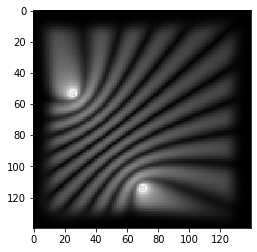

In [0]:
im_base = None

for i in range(train_images):
    sources, points = uniform_random_sources()

    sim = mp.Simulation(cell_size=cell,
                        resolution=resolution,
                        geometry=geometry,
                        sources=sources,
                        # symmetries=symmetries,
                        boundary_layers=pml_layers,
                        force_complex_fields=True)
    
    sim.init_sim() # takes 15s
    sim.solve_cw()

    arr = sim.get_array(component=mp.Ez)
    if im_base is None:
        im_base = plt.imshow(np.absolute(arr), norm=norm, cmap='gray')

    x_img = get_x_img(arr, points)
    y_img = phasor_to_png(arr, im_base=im_base)
    x_img.save(train_path/'x'/'train_{:04d}.png'.format(i))
    y_img.save(train_path/'labels'/'train_{:04d}_label.png'.format(i))

In [0]:
!7z a train.7z train/


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive:
  0M Scan           3 folders, 2000 files, 10842707 bytes (11 MiB)

Creating archive: train.7z

Items to compress: 2003

  0%      8% 189 + train/labels/train_0189_label.png                                             20% 303 + train/labels/train_0303_label.png                                             31% 420 + train/labels/train_0420_label.png                                             42% 528 + train/labels/train_0528_label.png         

In [0]:
shutil.rmtree(train_path)
try: os.remove('train.7z')
except FileNotFoundError: pass